# Apresentação:

O objetivo deste código é implementar a técnica de **Hierarchical Risk Parity (HRP)** para alocação de pesos em uma carteira de ativos financeiros. O **HRP** utiliza métodos de **clusterização hierárquica** e correlação para otimizar a diversificação da carteira, respeitando a paridade de risco entre os ativos.

In [30]:
# Bibliotecas Utilizadas:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Obter os Dados de Mercado
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']  # Substitua pelos tickers desejados
data = yf.download(tickers, start="2020-01-01", end="2024-10-05")['Adj Close'];data

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2020-01-02 00:00:00+00:00,72.876106,94.900497,68.201012,153.938202,28.684000
2020-01-03 00:00:00+00:00,72.167618,93.748497,67.866325,152.021408,29.534000
2020-01-06 00:00:00+00:00,72.742653,95.143997,69.539726,152.414337,30.102667
2020-01-07 00:00:00+00:00,72.400558,95.343002,69.496330,151.024673,31.270666
2020-01-08 00:00:00+00:00,73.565186,94.598503,70.043991,153.430267,32.809334
...,...,...,...,...,...
2024-09-30 00:00:00+00:00,233.000000,186.330002,167.190002,430.299988,261.630005
2024-10-01 00:00:00+00:00,226.210007,185.130005,168.419998,420.690002,258.019989
2024-10-02 00:00:00+00:00,226.779999,184.759995,167.309998,417.130005,249.020004


Para esse modelo, assim como a paridade de risco tradicional, trabalha-se em cima dos valores de retorno. Ou seja, para calcular a correlação, deve-se utilizar os retornos dos ativos. Isso é feito calculando os retornos logarítmicos dos preços de fechamento ajustados.

In [5]:
# Retornos diários como porcentagem
returns = data.pct_change().dropna();returns

Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2020-01-03 00:00:00+00:00,-0.009722,-0.012139,-0.004907,-0.012452,0.029633
2020-01-06 00:00:00+00:00,0.007968,0.014886,0.024657,0.002585,0.019255
2020-01-07 00:00:00+00:00,-0.004703,0.002092,-0.000624,-0.009118,0.038801
2020-01-08 00:00:00+00:00,0.016086,-0.007809,0.007880,0.015928,0.049205
2020-01-09 00:00:00+00:00,0.021241,0.004799,0.011044,0.012493,-0.021945
...,...,...,...,...,...
2024-09-30 00:00:00+00:00,0.022872,-0.008725,0.011495,0.005327,0.004492
2024-10-01 00:00:00+00:00,-0.029142,-0.006440,0.007357,-0.022333,-0.013798
2024-10-02 00:00:00+00:00,0.002520,-0.001999,-0.006591,-0.008462,-0.034881


# Elaborando a clusterização Hierarquica:

Esse método de otimização de portifólio são baseados na **teoria de Markowitz**, deste modo são muito ligados a correlação entre os ativos. Sendo assim, precisasmos avaliar a sua associação linear entre os elementos.

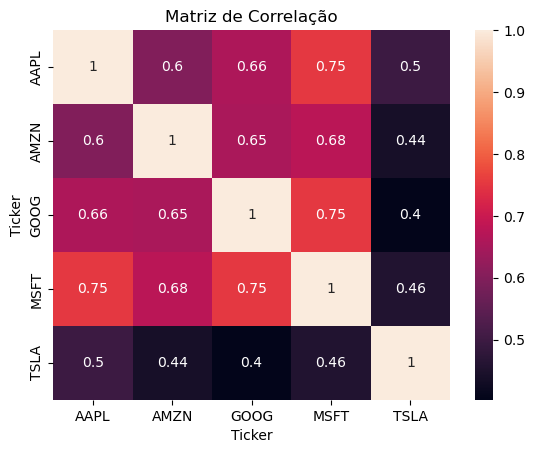

In [13]:
# Matriz de Correlação:
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Matriz de Correlação")
plt.show()

No HRP, precisamos converter a matriz de correlação em uma matriz de distância para fazer o clustering hierárquico. A relação entre a correlação e a distância é dada por:

$$D = \sqrt{0.5\times(1-\text{correlation})}$$

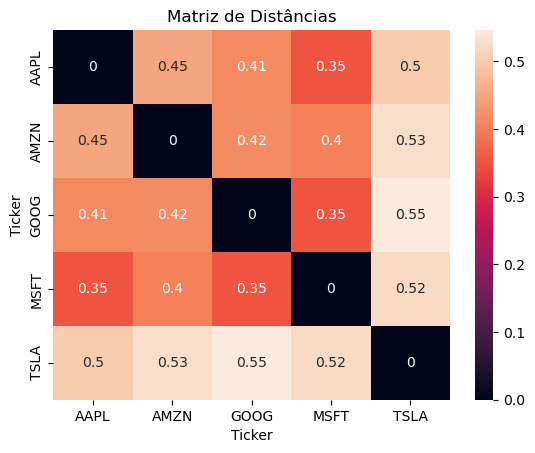

In [12]:
# Converte a Matriz de Correlação em Matriz de Distância
dist_matrix = np.sqrt(0.5 * (1 - corr_matrix))
sns.heatmap(dist_matrix, annot=True)
plt.title("Matriz de Distâncias")
plt.show()

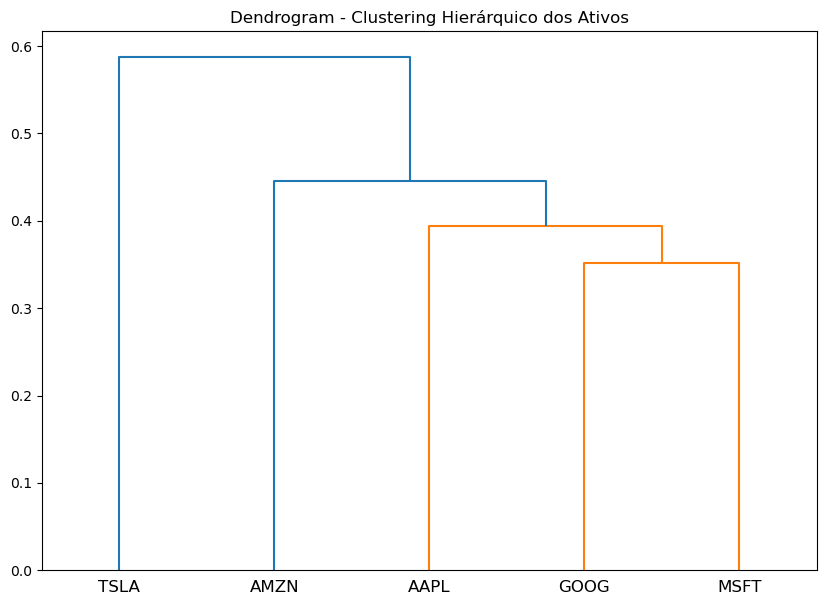

In [21]:
# Aplicando os cluster Hierárquicos:
condensed_dist_matrix = squareform(dist_matrix) # Gerando matrizes condensadas
linkage_matrix = linkage(condensed_dist_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=returns.columns)
plt.title("Dendrogram - Clustering Hierárquico dos Ativos")
plt.show()

Podemos formar os clusters de ativos com base no dendrograma. Neste exemplo, vamos formar os clusters com base na altura do linkage.


In [22]:
# Forma os Clusters
num_clusters = 3  # Defina o número de clusters desejado
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

In [25]:
# Inicializando os pesos de cada ativo como float
weights = pd.Series(0.0, index=returns.columns)  # Inicializando como 0.0 para garantir o tipo float

# Alocação de pesos entre clusters
cluster_weight = 1.0 / num_clusters

for cluster in range(1, num_clusters + 1):
    # Ativos no cluster atual
    cluster_assets = cluster_df[cluster_df['Cluster'] == cluster]['Asset']
    num_assets = len(cluster_assets)
    # Peso igual para cada ativo dentro do cluster
    asset_weight = cluster_weight / num_assets
    weights[cluster_assets] = asset_weight

# Exibindo os pesos finais da carteira
print("Pesos da carteira com HRP:")
print(weights)

Pesos da carteira com HRP:


Ticker
AAPL    0.111111
AMZN    0.333333
GOOG    0.111111
MSFT    0.111111
TSLA    0.333333
dtype: float64

In [29]:
# Validando Pesos:
if weights.sum() == 1:
    print("Respeita a sujeição dos pesos :>")
else:
    print(weights.sum())
    print("Não respeita a sujeição dos pesos")

Respeita a sujeição dos pesos :>


In [31]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Passo 1: Obter dados históricos dos preços dos ativos
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
data = yf.download(tickers, start="2022-01-01", end="2024-10-05")['Adj Close']

# Passo 2: Calcular os retornos diários dos ativos
returns = data.pct_change().dropna()

# Passo 3: Calcular a matriz de covariância dos retornos
cov_matrix = returns.cov()

# Função para calcular a contribuição ao risco de cada ativo
def risk_contribution(weights, cov_matrix):
    # Calcular a variância do portfólio
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    # Calcular as contribuições ao risco dos ativos
    marginal_risk = np.dot(cov_matrix, weights)
    risk_contributions = weights * marginal_risk / portfolio_volatility
    return risk_contributions

# Função de perda para minimizar a diferença entre as contribuições de risco
def loss_function(weights, cov_matrix):
    risk_contributions = risk_contribution(weights, cov_matrix)
    # Diferença entre as contribuições de risco e a contribuição média
    mean_contribution = np.mean(risk_contributions)
    return np.sum((risk_contributions - mean_contribution)**2)

# Definir as restrições e limites para a otimização
num_assets = len(tickers)
initial_weights = np.ones(num_assets) / num_assets  # Começando com pesos iguais
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # A soma dos pesos deve ser 1
bounds = [(0, 1) for i in range(num_assets)]  # Pesos devem ser entre 0 e 1

# Otimizar os pesos para alcançar a paridade de risco
result = minimize(loss_function, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Pesos finais da paridade de risco
weights = result.x

# Exibindo os pesos finais
print("Pesos da carteira com Paridade de Risco:")
for ticker, weight in zip(tickers, weights):
    print(f"{ticker}: {weight:.4f}")


[*********************100%***********************]  5 of 5 completed

Pesos da carteira com Paridade de Risco:
AAPL: 0.2000
MSFT: 0.2000
GOOG: 0.2000
AMZN: 0.2000
TSLA: 0.2000
